# Spotify Review NLP - Rating Prediction from Reviews on Google Play

The data was retrieved from https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022

This project aims at building an NLP machine that predicts the rating of the Spotify app based on the user reviews. A recurrent neural network will be used. Side information such as the number of upvotes and the time of publication will also be used as features.

Tensorflow Data module was used to allow possible application of Tensorflow dataset pipelines. StaticVocabularyTable was also used to provide greater flexibility in specifying the number of OOV buckets.

### EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
df = pd.read_csv('reviews.csv')

In [4]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [5]:
df.shape

(61594, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In [7]:
df.describe()

,Rating,Total_thumbsup
count,61594.000000,61594.000000
mean,3.155989,7.649381
std,1.673285,89.323143
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,5.000000,8195.000000


The mean of total upvotes of reviews grouped by the presence of replies

In [8]:
x = pd.concat((df['Total_thumbsup'], (df['Reply'].isna() == False).astype('str')), axis=1)
y = x.groupby('Reply')['Total_thumbsup'].mean()

Text(0, 0.5, 'Mean number of Upvotes')

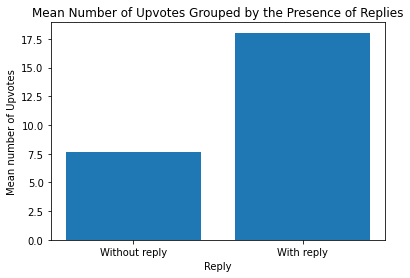

In [9]:
plt.bar(['Without reply', 'With reply'], y.values)
plt.title('Mean Number of Upvotes Grouped by the Presence of Replies')
plt.xlabel('Reply')
plt.ylabel('Mean number of Upvotes')

Distribution of ratings and the distribution of the number of upvotes

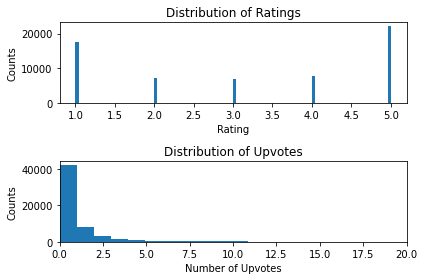

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.hist(df['Rating'].values, bins=100)
ax1.set_title('Distribution of Ratings')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Counts')
ax2 = fig.add_subplot(212)
ax2.hist(df['Total_thumbsup'][df['Total_thumbsup'] < 100].values, bins=100)
ax2.set_title('Distribution of Upvotes')
ax2.set_xlabel('Number of Upvotes')
ax2.set_ylabel('Counts')
ax2.set_xlim(0,20)
plt.tight_layout()
plt.show()

In [ ]:
df['Total_thumbsup'].max()

8195

In [ ]:
df['Time_submitted'] = pd.to_datetime(df['Time_submitted'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
group_month = df.groupby(df['Time_submitted'].dt.month)

In [ ]:
review_count_by_month = group_month['Rating'].count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  


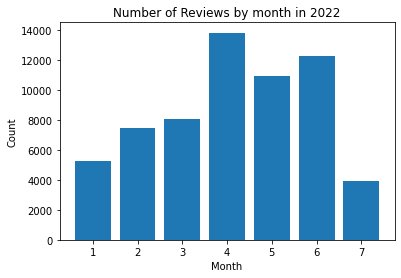

In [ ]:
plt.bar(review_count_by_month.index, review_count_by_month.values)
plt.gca().set_xticks([1,2,3,4,5,6,7], ['January', 'February', 'March', 'April', 'May', 'June', 'July'])
plt.title('Number of Reviews by month in 2022')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

### Preprocessing

Lower Case

In [ ]:
df['Review'] = df['Review'].str.lower()

Remove Punctuations

In [ ]:
df['Review'] = df['Review'].str.replace('[^\w ]+', '', regex=True)

Lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

lm = WordNetLemmatizer()

def lemmatize(sentence):
    new_words = []
    words = sentence.split(' ')
    for word in words:
        new_words.append(lm.lemmatize(word))
    return ' '.join(new_words)

df['Review'] = df['Review'].apply(lemmatize)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
X_full = df['Review'].values
y_full = df['Rating'].values

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, test_size=0.1)

In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices((tf.constant(X_train), tf.constant(y_train)))
dataset_valid = tf.data.Dataset.from_tensor_slices((tf.constant(X_valid), tf.constant(y_valid)))

In [ ]:
for i in dataset_train.take(1):
    print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'good app for streaming but im always late to update i have auto update on and i still dont have most of the feature all my friend have just a little annoyed'>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)


In [ ]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.split(X_batch)
    X_batch = X_batch.to_tensor(default_value=b'<pad>')
    return X_batch, y_batch

In [ ]:
for i in preprocess(X_full[0:2], y_full[0:2])[0]:
    print(i)

tf.Tensor(
[b'great' b'music' b'service' b'the' b'audio' b'is' b'high' b'quality'
 b'and' b'the' b'app' b'is' b'easy' b'to' b'use' b'also' b'very' b'quick'
 b'and' b'friendly' b'support'], shape=(21,), dtype=string)
tf.Tensor(
[b'please' b'ignore' b'previous' b'negative' b'rating' b'this' b'app'
 b'is' b'super' b'great' b'i' b'give' b'it' b'five' b'star' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'], shape=(21,), dtype=string)


In [ ]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in dataset_train.batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [ ]:
vocabulary.most_common()[:5]

[(b'<pad>', 1939570),
 (b'the', 60484),
 (b'i', 58587),
 (b'to', 55365),
 (b'it', 50450)]

In [ ]:
len(vocabulary)

25489

In [ ]:
vocab_size = 8000
truncated_vocabulary = [word for word, count in vocabulary.most_common()[:vocab_size]]

In [ ]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}

In [ ]:
for word in b'this app is great'.split():
    print(word_to_id[word])

15
7
9
41


In [ ]:
for word, index in word_to_id.items():
    if index == 1000:
        print(word)

b'mine'


In [ ]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets=num_oov_buckets)

In [ ]:
table.lookup(tf.constant([b'this app is great'.split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[15,  7,  9, 41]])>

In [ ]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = dataset_train.batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

valid_set = dataset_valid.batch(32).map(preprocess)
valid_set = valid_set.map(encode_words).prefetch(1)

In [ ]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  35    7   12 ...    0    0    0]
 [ 517  509   17 ...    0    0    0]
 [   2   64   31 ...    0    0    0]
 ...
 [ 547 8573   10 ...    0    0    0]
 [  35    7   12 ...    0    0    0]
 [  71   14   92 ...    0    0    0]], shape=(32, 58), dtype=int64)
tf.Tensor([3 1 4 1 5 2 5 3 1 1 5 5 2 5 1 5 5 4 5 3 5 5 3 2 4 5 5 1 5 5 5 1], shape=(32,), dtype=int64)


In [ ]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size+num_oov_buckets, embed_size,
                           mask_zero = True,
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True, kernel_regularizer='l2'),
    keras.layers.LayerNormalization(),
    keras.layers.GRU(128, kernel_regularizer='l2'),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss='mean_squared_error', metrics=tf.keras.metrics.RootMeanSquaredError(), optimizer='adam')
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
1733/1733 [==============================] - 43s 20ms/step - loss: 1.5781 - root_mean_squared_error: 1.0877 - val_loss: 1.0326 - val_root_mean_squared_error: 0.9860
Epoch 2/5
1733/1733 [==============================] - 31s 18ms/step - loss: 0.9272 - root_mean_squared_error: 0.9320 - val_loss: 1.0221 - val_root_mean_squared_error: 0.9857
Epoch 3/5
1733/1733 [==============================] - 32s 19ms/step - loss: 0.7712 - root_mean_squared_error: 0.8405 - val_loss: 1.1210 - val_root_mean_squared_error: 1.0288
Epoch 4/5
1733/1733 [==============================] - 31s 18ms/step - loss: 0.6697 - root_mean_squared_error: 0.7729 - val_loss: 1.2890 - val_root_mean_squared_error: 1.1028
Epoch 5/5
1733/1733 [==============================] - 30s 18ms/step - loss: 0.6154 - root_mean_squared_error: 0.7342 - val_loss: 1.2973 - val_root_mean_squared_error: 1.1047


In [ ]:
model.predict(table.lookup(tf.constant([b'this app is good'.split()])))

array([[4.7798686]], dtype=float32)